In [11]:
# Task 2: CNN‑Based Soil Image Classification  
#This notebook covers:
# 1. Project paths & imports  
# 2. Data re‑organization & quality checks  
# 3. Data exploration & augmentation  
# 4. Model definition  
# 5. Training with callbacks  
# 6. Evaluation & confusion matrix  
# 7. Feature embedding (t‑SNE)  
# 8. Saving the model  


In [12]:
import os, random, shutil
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import itertools

# Resolve project paths (this notebook lives in PROJECT_ROOT/notebook)
PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
DATA_DIR     = os.path.join(PROJECT_ROOT, 'Dataset')
OUTPUT_DIR   = os.path.join(PROJECT_ROOT, 'saved_model')
os.makedirs(OUTPUT_DIR, exist_ok=True)

print("Project root:", PROJECT_ROOT)
print("Looking for images in:", DATA_DIR)
print("Initial contents:", os.listdir(DATA_DIR))

# TensorFlow & other imports
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.manifold import TSNE

# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)


Project root: /Users/emmanuelbassey/Downloads/assignments/ml/assignment2-3092017-ML
Looking for images in: /Users/emmanuelbassey/Downloads/assignments/ml/assignment2-3092017-ML/Dataset
Initial contents: ['Forest', 'River', 'Highway', 'AnnualCrop', 'SeaLake', 'HerbaceousVegetation', 'Industrial', 'Residential', 'PermanentCrop', 'Pasture']


In [13]:
# Move flat image files into subfolders by the prefix before '_'
for fname in os.listdir(DATA_DIR):
    if fname.lower().endswith(('.jpg', '.jpeg', '.png')):
        cls = fname.split('_')[0]
        cls_dir = os.path.join(DATA_DIR, cls)
        os.makedirs(cls_dir, exist_ok=True)
        shutil.move(os.path.join(DATA_DIR, fname), os.path.join(cls_dir, fname))


In [14]:
# Image specs & detect classes
IMG_H, IMG_W = 64, 64

CLASS_NAMES = sorted(d for d in os.listdir(DATA_DIR)
                     if os.path.isdir(os.path.join(DATA_DIR, d)))
NUM_CLASSES = len(CLASS_NAMES)
print(f"Detected {NUM_CLASSES} classes:", CLASS_NAMES)

# Check for corrupted or wrong‑sized images
bad_files = []
for cls in CLASS_NAMES:
    cls_dir = os.path.join(DATA_DIR, cls)
    for fn in os.listdir(cls_dir):
        path = os.path.join(cls_dir, fn)
        try:
            img = Image.open(path); img.verify()
            if img.size != (IMG_W, IMG_H):
                bad_files.append(path)
        except:
            bad_files.append(path)

print("Problematic files detected:", len(bad_files))
# (Optionally remove or move them)


Detected 10 classes: ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']
Problematic files detected: 0


In [15]:
BATCH_SIZE = 32
VAL_SPLIT  = 0.15

datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=VAL_SPLIT,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    fill_mode='reflect'
)

train_gen = datagen.flow_from_directory(
    DATA_DIR,
    target_size=(IMG_H, IMG_W),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    seed=SEED
)
val_gen = datagen.flow_from_directory(
    DATA_DIR,
    target_size=(IMG_H, IMG_W),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    seed=SEED
)


Found 22950 images belonging to 10 classes.
Found 4050 images belonging to 10 classes.


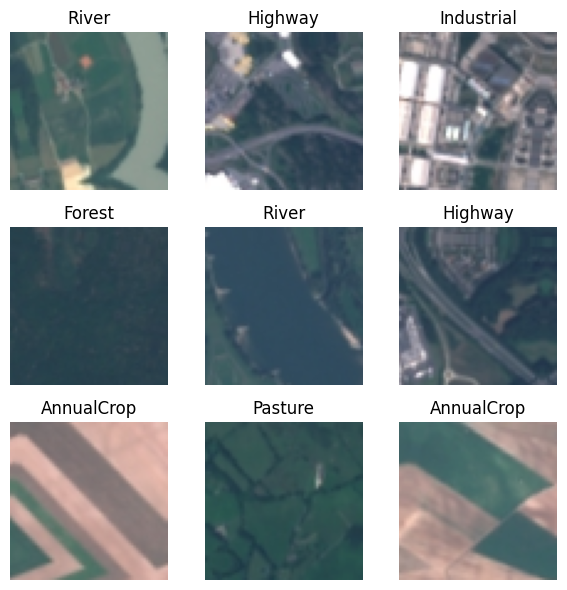

In [16]:
plt.figure(figsize=(6,6))
train_gen.reset()
imgs, labels = next(train_gen)
for i in range(9):
    ax = plt.subplot(3,3,i+1)
    plt.imshow(imgs[i])
    plt.title(CLASS_NAMES[np.argmax(labels[i])])
    plt.axis('off')
plt.tight_layout()
plt.show()


In [17]:
def build_rgb_cnn(input_shape=(IMG_H, IMG_W, 3), num_classes=NUM_CLASSES):
    inp = keras.Input(shape=input_shape)
    x = layers.Conv2D(32,3,activation='relu')(inp); x = layers.MaxPool2D()(x)
    x = layers.Conv2D(64,3,activation='relu')(x); x = layers.MaxPool2D()(x)
    x = layers.Conv2D(128,3,activation='relu')(x); x = layers.MaxPool2D()(x)
    x = layers.Flatten()(x)
    x = layers.Dense(128,activation='relu')(x); x = layers.Dropout(0.5)(x)
    out = layers.Dense(num_classes,activation='softmax')(x)
    return keras.Model(inp, out, name='RGB_CNN')

model = build_rgb_cnn()
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()


Model: "RGB_CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       589,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 684,490 (2.61 MB)

 Trainable params: 684,490 (2.61 MB)

 Non-trainable params: 0 (0.00 B)

In [18]:
# ==== Cell 8: Training (revised) ====
EPOCHS = 25
steps_per_epoch  = len(train_gen)    # train_gen.samples // train_gen.batch_size
validation_steps = len(val_gen)      # val_gen.samples // val_gen.batch_size

callbacks = [
    keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=5, restore_best_weights=True
    ),
    keras.callbacks.ModelCheckpoint(
        filepath=os.path.join(OUTPUT_DIR, 'best.h5'),
        save_best_only=True,
        monitor='val_accuracy'
    )
]

history = model.fit(
    train_gen,
    epochs=EPOCHS,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_gen,
    validation_steps=validation_steps,
    callbacks=callbacks
)

# Plot training accuracy
plt.figure()
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training vs. Validation Accuracy')
plt.show()


Epoch 1/25


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


137/718 ━━━━━━━━━━━━━━━━━━━━ 22s 39ms/step - accuracy: 0.2023 - loss: 2.0479

KeyboardInterrupt: 

In [ ]:
# Predict & report
y_true = val_gen.classes
val_gen.reset()
y_pred = model.predict(val_gen).argmax(axis=1)

print(classification_report(y_true, y_pred, target_names=CLASS_NAMES))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,6))
plt.imshow(cm, cmap=plt.cm.Blues)
plt.xticks(range(NUM_CLASSES), CLASS_NAMES, rotation=45)
plt.yticks(range(NUM_CLASSES), CLASS_NAMES)
thresh = cm.max()/2
for i,j in itertools.product(range(NUM_CLASSES), range(NUM_CLASSES)):
    plt.text(j,i,cm[i,j],ha='center',
             color='white' if cm[i,j]>thresh else 'black')
plt.ylabel('True'); plt.xlabel('Predicted')
plt.title('Confusion Matrix'); plt.tight_layout(); plt.show()


In [ ]:
# t-SNE embedding of penultimate layer
feat_extractor = keras.Model(
    inputs=model.input,
    outputs=model.layers[-3].output
)
imgs, labs = next(val_gen)
feats = feat_extractor.predict(imgs)

emb = TSNE(n_components=2, random_state=SEED).fit_transform(feats)
plt.figure(figsize=(8,6))
for idx, cls in enumerate(CLASS_NAMES):
    mask = np.argmax(labs, axis=1)==idx
    plt.scatter(emb[mask,0], emb[mask,1], label=cls, alpha=0.7)
plt.legend(); plt.title('t-SNE Feature Space'); plt.show()

# Save final model
model.save(os.path.join(OUTPUT_DIR, 'final.h5'))
print("Model saved to", os.path.join(OUTPUT_DIR, 'final.h5'))
